In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd

from fsvc_watermarking import fsvc_watermark_embedding, fsvc_watermark_detection
from patchwork_watermarking import patchwork_watermark_embedding, patchwork_watermark_detection
from norm_space_watermarking import norm_space_watermark_embedding, norm_space_watermark_detection
from dct_watermarking import get_watermark_length, dctb1_watermark_embedding, dctb1_watermark_detection
import warnings
warnings.filterwarnings("ignore")

# Audio Watermarking
## Proyecto N°2 Procesamiento de Voz 

Autores:
- Pablo Smolkin
- Francisco Ledesma

## ¿Qué es el watermarking?
En términos generales, es un proceso que involucra modificar el contenido de un archivo, de forma perceptible o no perceptible, con el objetivo de dar información sobre el dueño del mismo o de protegerlo contra copias no autorizadas.

El caso más popular es el de las imágenes, donde se suele agregar texto sobre la imagen de forma que no sea removible fácilmente sin alterar de forma notable el contenido deseado.

En el caso de audio, el watermarking se puede realizar agregando información a la señal original, de forma que no sea perceptible para el oído humano, pero que pueda ser detectado por un algoritmo. De esta forma, si bien no actúa como una barrera perceptible contra la copia, sí permite detectar el uso de material protegido.

## Metricas
Las métricas utilizadas para cuantizar la calidad de una técnica de watermarking son similares a las usadas para evaluar otros métodos de síntesis de audio, en términos de la calidad del sonido. Es decir, métricas objetivas como el SNR, y métricas subjetivas como el MOS o PESQ.

Además, se deben evaluar características respecto de la información transmitida. La capacidad de transmisión se puede medir con la tasa de error de bits (BER). La robustez refiere a la posibilidad de detección del watermark frente a ataques comunes como agregado de ruido, filtrado, o compresión. La seguridad refiere a la dificultad de detectar el watermark sin autorización.

En la evaluación de las implementaciones de este proyecto, se utilizarán las métricas de SNR y BER, y se tendrá en cuenta la calidad perceptual, asumiendo un entorno libre de ruido o ataques.

### Bit Error Rate

\begin{equation*}
BER = \frac{1}{N} \sum_{i=1}^{N} w_i \oplus \hat{w}_i
\end{equation*}

* N es el número total de bits en la marca de agua.
* $w_i$ es el i-ésimo bit de la secuencia original.
* $\hat{w}_i$ es el i-ésimo bit de la secuencia detectada.
* La función a $\oplus$ b devolvera un arreglo con tantos 1's como bits distintos haya.


### Signal to Noise Ratio

\begin{equation*}
SNR = 10 \log_{10}\left(\frac{\sum_{i=1}^{N} s_i^2}{\sum_{i=1}^{N} (s_i - \hat{s}_i)^2}\right)
\end{equation*}

In [2]:
def calculate_ber(watermark, watermark_detected):
  return np.sum(watermark != watermark_detected)/len(watermark)

# following function calculate the SNR from the original and watermarked signal
def calculate_snr(original_signal, watermarked_signal):
  noise = original_signal - watermarked_signal
  return 10*np.log10(np.sum(original_signal**2)/np.sum(noise**2))

In [3]:
# dictionary to compare the different watermarking methods
watermarking_methods = {
    'Implementacion 1': {
        'SNR [dB]': 0,
        'BER [%]': 0
    },
    'Implementacion 2': {
        'SNR [dB]': 0,
        'BER [%]': 0
    },
    'Implementacion 3': {
        'SNR [dB]': 0,
        'BER [%]': 0
    }
}

In [4]:
# Import recorded speech signals
fs_hamlet, hamlet_en = wavfile.read('audios/Hamlet.wav')
hamlet_en = np.mean(hamlet_en, axis=1)
t_hamlet = np.arange(0, 4, 1/fs_hamlet)
print('Hamlet.wav: ', hamlet_en.shape, fs_hamlet)
Audio(hamlet_en, rate=fs_hamlet)

Hamlet.wav:  (176400,) 44100


## Implementaciones evaluadas
A continuación se encuentran las pruebas realizadas con tres implementaciones distintas de watermarking. Cada una fue propuesta en un paper distinto, y se le asignarán nombres particulares para poder diferenciarlas en la presentación.

* **Implementación 1**: Propuesta en el paper "Robust, transparent and high-capacity audio watermarking in DCT domain". En particular, la técnica de embedding en la primera banda de coeficientes.
* **Implementación 2**: Propuesta en el paper "Patchwork-Based Multilayer Audio Watermarking". En particular, la técnica de embedding en la primera capa.
* **Implementación 3**: Propuesta en el paper "Novel secured scheme for blind audio/speech norm-space watermarking by Arnold algorithm".

## Implementación 1

* En general, las tecnicas de watermarking en audio se basan en modular las componentes de baja frecuencia de las señales de audio.
* Para el analisis espectral se suele utilizar la DFT, DCT y DWT.
* DWT tiene mayor complejidad computacional. La diferencia entre la DFT y la DCT es que la DCT solo usa funciones coseno.
* Como la DCT asume simitria continua en los limites, la DCT tiende a concentrar la energia en los coeficientes de baja frecuencia. Por este motivo el autor habla de "compactacion espectral" y refiere a que por este motivo la DCT es adecuada para aplicaciones de compresion.

### Introduccion:
La tecnica se aplica ventana a ventana de longitud 'lf'.

Cada ventana tiene dos secciones: 
* 'lt': una sección pequeña de muestras para suavizar la transición entre ventanas.
* 'lw': una sección grande de muestras convertidas en coeficientes DCT para colocar la marca de agua.

El autor del paper sugiere utilizar, para una señal muestreada a 44.1 kHz lt = 64 y lw = 4096.
La señal muestreada a 44.1 kHz resulta en una resolución temporal de 94.3 ms y una resolución de frecuencia de 5.38 Hz con una DCT de 4096 puntos.
Se utiliza una ventana más grande para obtener una alta resolución espectral.

El enfoque principal es cómo manipular los coeficientes DCT en cada ventana.

Se aprovecha las propiedades de enmascaramiento auditivo para ocultar la marca de agua en un sonido de mayor intensidad dentro de cada banda crítica. Se asume que el umbral de enmascaramiento auditivo estimado se mantiene aproximadamente a un nivel fijo en cada banda, y cada banda contiene suficientes coeficientes DCT para acomodar la variación de energía debido a la marca de agua. Como las señales de audio concentran su energia en frecuencia por debajo de 1kHz el proceso se enfoca en los primeros 168 coeficientes DCT, que se dividen en tres bandas de frecuencia, cada una cubriendo un rango de 301.46 Hz para la frecuencia de muestreo dada.

### Enmascaramiento auditivo

Según la teoría del enmascaramiento auditivo, una marca de agua insertada será inaudible si la distorsión de energía se encuentra por debajo del umbral de enmascaramiento.
Se toma la mitad de una banda de frecuencia como la frecuencia representativa $f_{rep}$ y se convierte a una escala Bark.
\begin{equation*}
z_{\text{rep}} = 13 \tan^{-1}(0.00076f_{\text{rep}}) + 3.5 \tan^{-1}\left(\left(\frac{f_{\text{rep}}}{7500}\right)^2\right)
\end{equation*}

Luego, el umbral de enmascaramiento auditivo para una banda con una frecuencia central Bark $z_{\text{rep}}$ es:
\begin{equation*}
a(z_{\text{rep}}) = \lambda a_{\text{tmn}}(z_{\text{rep}}) + (1-\lambda)a_{\text{n\text{mn}}}(z_{\text{rep}})
\end{equation*}
Donde λ es el factor de tonalidad que varía entre 0 y 1. $a_{\text{tmn}}(z)$ es el índice de enmascaramiento tono-ruido, que se estima como $a_{\text{tmn}}(z) = 0.275z + 15.025$, y $a_{\text{n\text{mn}}}(z)$ es el índice de enmascaramiento ruido-ruido, que se fija generalmente en $a_{\text{n\text{mn}}}(z) = -9$.

$a_{\text{tmn}}(z_{\text{rep}})$ puede considerarse como el nivel máximo permisible de variación de energía sin causar una distorsión notable, especialmente en frecuencias cercanas a $z_{\text{rep}}$.


Por lo tanto, la marca de agua incrustada se volverá imperceptible si la variación de energía no supera $E_{\text{mask}}$
\begin{equation*}
E_{\text{mask}} = 10^{a_{\text{tmn}}(z_{\text{rep}})/10}E_c \text{    ;\;\;    con   } E_c = \sum_{i=1}^{56}c_i^2
\end{equation*}

### QIM

Los 56 coeficientes en una banda de frecuencia se dividen en dos grupos: G1 y G2. 
Cada grupo contiene índices de coeficientes DCT, con G1 teniendo los índices de LG1 coeficientes y G2 teniendo los índices de LG2 coeficientes.

Los coeficientes DCT en el grupo G1 seran utilizados para colocar la marca de agua. Por otro lado, los coeficientes en el grupo G2 están destinados a absorber la variación de energía que resulta de colocar la marca de agua. La idea de esto es mantener un nivel de energía constante que permitirá recuperar los pasos de cuantificación de la señal con la marca de agua.

Aumentar la proporción de LG1 a LG2 aumentará la capacidad del payload. Sin embargo, hay un límite en la cantidad de absorción de energía que cada coeficiente puede manejar. 

El autor del paper, de manera experimental, eligió los tamaños de LG1 y LG2 como 48 y 8, respectivamente.

Los indices que corresponden a G1 y a G2 se eligen de manera aleatoria. Se podria implementar una semilla para generar la secuencia aleatoria y que se utilize como una clave secreta.

Para introducir cada bit $w_b$ de la marca de agua en cada coeficiente de G1 se sigue la regla QIM que dice:

\begin{equation*}
\hat{c_k} = 
\begin{cases} 
\left\lfloor \frac{c_k}{\Delta} + 0.5 \right\rfloor\Delta, & \text{si } w_b = 0 \\
\left\lfloor \frac{c_k}{\Delta} \right\rfloor \Delta + \frac{\Delta}{2}, & \text{si } w_b = 1 
\end{cases}
\end{equation*}

donde $\hat{c_k}$ es la version cuantizada de $c_k$. $\Delta$ se calcula como:
\begin{equation*}
\Delta = \sqrt{E_{\text{mask}}}
\end{equation*}


  De esta manera, en cada frame tenemos LG1 bits del mensaje en esta banda de frecuencia.

### Compensar la variacion de energia de los coeficiente G1

Se ajusta la magnitud de los coeficientes G2 de forma tal que se compensen las variaciones de energia en G1 por la modulacion pero con el limite de que cada coeficiente no puede variar mas que $\frac{\Delta}{2}$

### Transiciones suaves entre ventanas

La modulacion de los coeficientes DCT pueden producir discontinuidades abruptas en los extremos de cada ventana. Esto puede producir que se escuchen clicks en el audio con marca de agua. Para solucionar esto, luego de aplicar la inversa de la DCT se aplica una interpolacion lineal en los extremos de las ventanas para eliminar las transiciones abruptas.

### Extraccion de la marca de agua

Luego, para extraer la marca de agua, conociendo el indice de los coeficientes modulados, se aplica la siguiente regla de decisión

\begin{equation*}
\tilde{w}_b = 
\begin{cases} 
1, & \text{si } \left| \frac{c_k}{\Delta} - \left\lfloor \frac{c_k}{\Delta} \right\rfloor - 0.5 \right| < 0.25 \\
0, & \text{caso contrario } 
\end{cases}
\end{equation*}



In [5]:
# Parameters
lt = 64
lw = 4096
lG1 = 48
lG2 = 8
band_size = lG1+lG2

# Create watermark
watermark_lenght_dct = get_watermark_length(signal=hamlet_en, lt=lt, lw=lw, lG1=lG1)
watermark_dct = np.tile(np.array([1, 0]), watermark_lenght_dct//2)

# Embed watermark
watermarked_signal_dct, G1_inds = dctb1_watermark_embedding(signal=hamlet_en, watermark=watermark_dct, sr=fs_hamlet, lt=lt, lw=lw, band_size=band_size, lG1=lG1, lG2=lG2)

# Detect watermark
detected_watermark_dct = dctb1_watermark_detection(watermarked_signal=watermarked_signal_dct, sr=fs_hamlet, G1_inds=G1_inds, lt=lt, lw=lw, band_size=band_size)

print(f"BER = {calculate_ber(watermark_dct, detected_watermark_dct)*100:.2f}%")
watermarking_methods['Implementacion 1']['BER [%]'] = calculate_ber(watermark_dct, detected_watermark_dct)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_dct):.2f} dB")
watermarking_methods['Implementacion 1']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_dct)

BER = 0.25%
SNR = 10.03 dB


In [6]:
# Play watermarked signal
Audio(data=watermarked_signal_dct, rate=fs_hamlet)

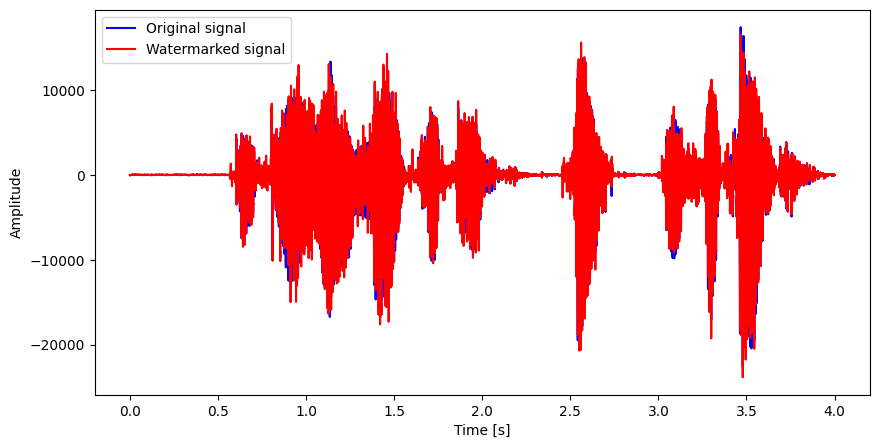

In [7]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t_hamlet, hamlet_en, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t_hamlet, watermarked_signal_dct, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
# plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

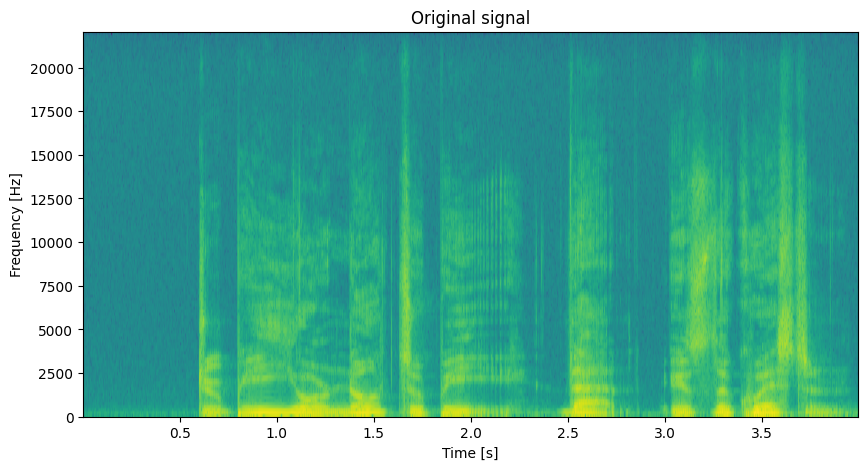

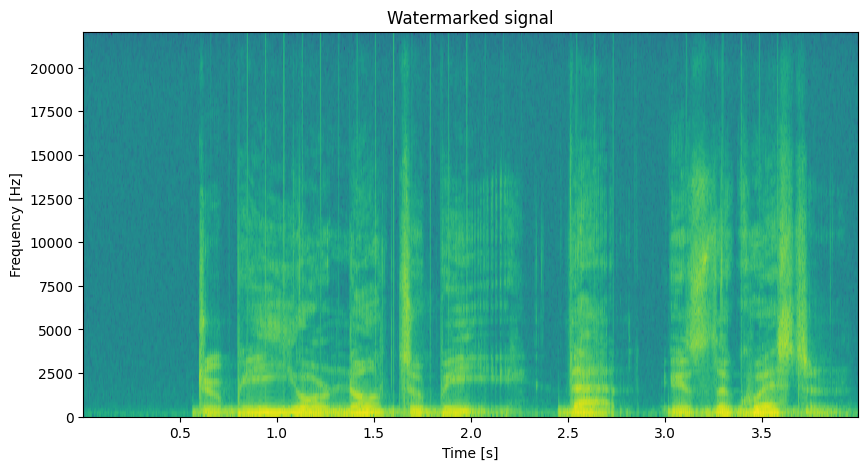

In [8]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_dct, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

## Implementación 2

* La señal de audio original se divide en segmentos.
* Se calculan los coeficientes de la transformada discreta del coseno (DCT) de estos segmento.
* Se descartan los coeficientes DCT correspondientes a los componentes de frecuencia baja y alta. Ya que se busca evitar que se pueda perder el watermark por compresion o por filtrado.
* Los coeficientes DCT restantes se ordenan de manera específica para reducir la necesidad de modificaciones y mejorar la calidad perceptual.
* Los coeficientes DCT ordenados se dividen en segmentos DCT.
* Para colocar un bit de marca de agua de capa 1, se consideran dos segmentos DCT adyacentes como un par de fragmentos.
* Los valores medios de cada fragmento en un par de fragmentos se modifican de acuerdo con la regla de incrustación diseñada.

### Se obtienen los coeficientes DCT

\begin{equation*}
X(k) = l(k) ∑_{n=0}^{L-1} x(n) cos(π(2n + 1)k / 2L) (1)
\end{equation*}

donde k = 0, 1,...,L - 1, y
\begin{equation*}
l(k) =  
\begin{cases} 
\sqrt{\frac{1}{L}}, & \text{si } k = 0 \\
\sqrt{\frac{2}{L}}, & \text{si } 1 \leq k < L 
\end{cases}
\end{equation*}

Luego, los coeficientes DCT correspondientes a un cierto rango de frecuencia [fs , fe ], denotados por $X_s(k)$, se seleccionan de $X(k)$.

### Reordenamiento de Coeficientes DCT
La energia de $X_s(k)$ esta tipicamente concentrada en las frecuencias mas bajas, para reducir la degradacion de la calidad perceptual al colocar bits de marca de agua se reordenan los coeficientes de forma tal que al dividir en segmentos las medias queden similares. Por lo tanto, queda $X_s'(k)$ de largo $L_S$

\begin{equation*}
Xs' (k) = [Xs (0), Xs (Ls − 1), Xs (1), Xs (Ls − 2), Xs (2), Xs (Ls − 3),...,Xs (Ls/2 − 1), Xs (Ls/2)]
\end{equation*}

Se divide $Xs' (k)$ en $Ns$ segmentos DCT de igual longitud $Xs',i(k)$, es decir, i = 1, 2,...,Ns:

\begin{equation*}
Xs',i(k)=[Xs',i(0), Xs',i(1),...,Xs',i(Ns − 1)]
\end{equation*}

El algoritmo coloca bits de marca de agua alterando $E(|Xs',i(k)|)s$, donde E(·) representa la operación de promedio y i = 1, 2,...,Ns. 

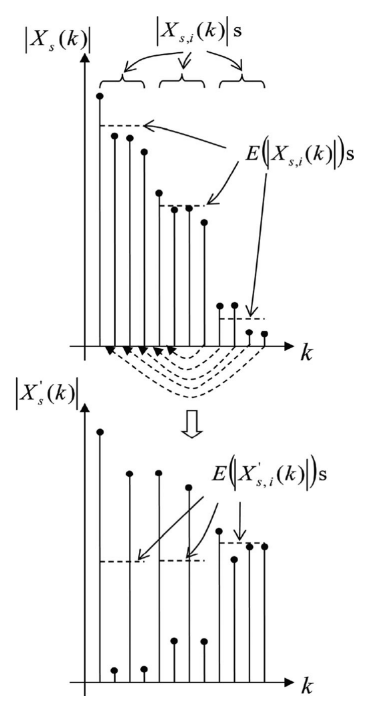

### Regla para colocar la marca de agua

En el método propuesto, un bit de marca de agua se coloca en dos segmentos adyacentes de coeficientes DCT reordenados. Llamamos a esos dos grupos un par de fragmentos. Denotamos un par de fragmentos de capa-j como Xf1,j (k) y Xf2,j (k), donde j = 1, 2,...,N. 

Definimos las medias de los fragmentos de valor absoluto como:

\begin{equation*}
\begin{cases} 
m1,j = E(|Xf1,j (k)|) \\
m2,j = E(|Xf2,j (k)|) 
\end{cases}
\end{equation*}

y definimos además los términos siguientes

\begin{equation*}
\begin{cases} 
mj = \dfrac{(m1,j + m2,j)}{2} \\
mmj = \min\{m1,j , m2,j \} 
\end{cases}
\end{equation*}

Para compensar los errores causados por el cambio en los valores medios, se introduce un buffer de error para mejorar la robustez del algoritmo. Definimos un parámetro de buffer de error de capa-j como rj.

Luego, si se quiere colocar un '0':
\begin{equation*}
m'1,j =  
\begin{cases} 
m1,j & \text{si } (m1,j - m2,j) \geq rj \cdot mmj, \\
mj + (rj \cdot mmj / 2) & \text{en caso contrario},
\end{cases}
\end{equation*}

\begin{equation*}
m'2,j = 
\begin{cases} 
m2,j & \text{si } (m1,j - m2,j) \geq rj \cdot mmj, \\
mj - (rj \cdot mmj / 2) & \text{en caso contrario}.
\end{cases}
\end{equation*}

Luego, si se quiere colocar un '1':

\begin{equation*}
m'1,j =  
\begin{cases} 
m1,j & \text{si } (m2,j - m1,j) \geq rj \cdot mmj, \\
mj - (rj \cdot mmj / 2) & \text{en caso contrario},
\end{cases}
\end{equation*}

\begin{equation*}
m'2,j = 
\begin{cases} 
m2,j & \text{si } (m2,j - m1,j) \geq rj \cdot mmj, \\
mj + (rj \cdot mmj / 2) & \text{en caso contrario}.
\end{cases}
\end{equation*}


Después de calcular m'1,j y m'2,j, los fragmentos de marca de agua colocados, denotados como Yf1,j (k) y Yf2,j (k) respectivamente, se obtienen de la siguiente manera:

\begin{equation*}
\begin{cases} 
Yf1,j = Xf1,j * (m'1,j / m1,j) \\
Yf2,j = Xf2,j * (m'2,j / m2,j)
\end{cases}
\end{equation*}

Luego de calcular todos los fragmentos, se re ordenan volviendo a la posicion original. Posteriormente, se calculan los segmentos de audio con la marca de agua mediante la IDCT.

### Extraccion del watermark

Se calcula por segmentos la DCT y se reordenan como se vio previamente. Luego se calcula:

\begin{equation*}
\begin{cases} 
m'1,j = E(|Yf1,j (k)|) \\
m'2,j = E(|Yf2,j (k)|) 
\end{cases}
\end{equation*}

Luego, usando esos valores medios se calcula la diferencia:

\begin{equation}
d_j = m'_{1,j} - m'_{2,j}
\end{equation}

El criterio de decisión de extracción de la marca de agua es el siguiente: 

se extrae el bit de marca de agua "0" de un par de fragmentos con marca de agua si $d_j \geq 0$. De lo contrario, se extrae el bit de marca de agua "1" del par de fragmentos.

In [9]:
watermark_patch = np.tile(np.array([1, 0]), 2**10)

watermarked_signal_patch = patchwork_watermark_embedding(signal=hamlet_en, watermark=watermark_patch, sr=fs_hamlet)

detected_watermark_patch = patchwork_watermark_detection(watermarked_signal=watermarked_signal_patch, watermark_length=len(watermark_patch), sr=fs_hamlet)

print(f"BER = {calculate_ber(watermark_patch, detected_watermark_patch)*100:.2f}%")
watermarking_methods['Implementacion 2']['BER [%]'] = calculate_ber(watermark_patch, detected_watermark_patch)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_patch):.2f} dB")
watermarking_methods['Implementacion 2']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_patch)

BER = 20.12%
SNR = 34.50 dB


In [10]:
Audio(hamlet_en, rate=fs_hamlet)

In [11]:
Audio(watermarked_signal_patch, rate=fs_hamlet)

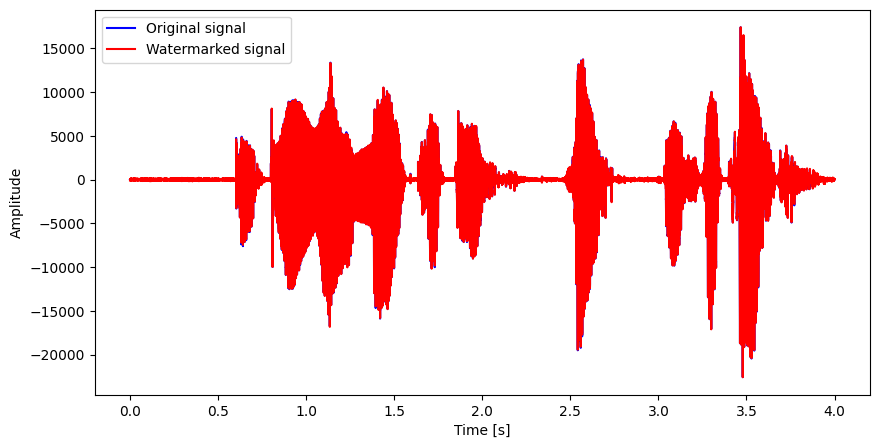

In [20]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t_hamlet, hamlet_en, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t_hamlet, watermarked_signal_patch, label="Watermarked signal", color=(1.0, 0, 0, 1.0)) 
# plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

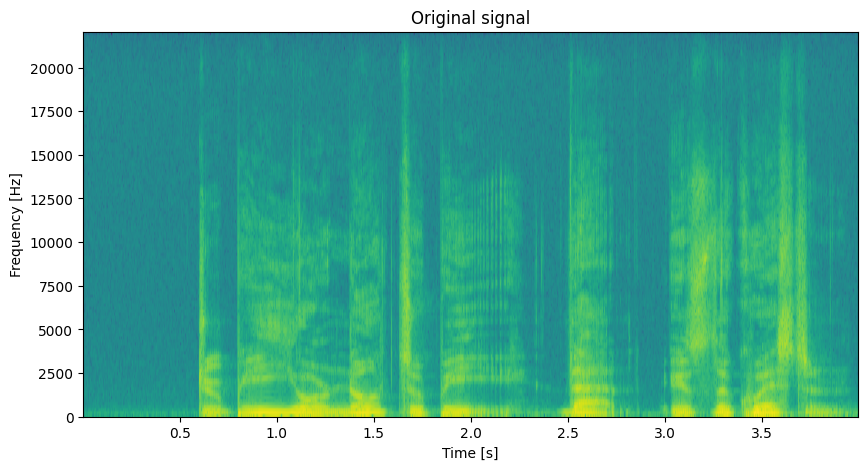

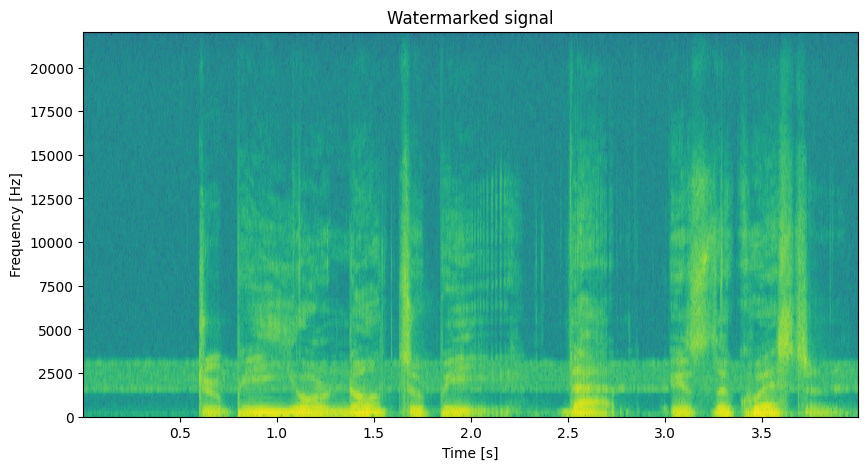

In [13]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_patch, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

## Implementación 3

La implementación de este algoritmo se puede detallar en los siguientes pasos:

**Embedding**

1. Dividir el audio original en tantos frames como bits de watermarking se quieran transmitir.
Para cada frame:
2. Aplicar un nivel de la transformada DWT, obteniendo los coeficientes cA1 (baja frecuencia, aproximación) y cD1 (alta frecuencia, detalle).
3. Aplicar la transformada DCT a los coeficientes cA1, y llamar al vector resultante V.
4. Descomponer V en dos subvectores, V1 y V2, de igual tamaño, tomando las muestras de indice par e impar respectivamente.
5. Aplicar la norma2 a cada subvector, y llamar a los resultados nrmv1 y nrmv2. Dividir V1 y V2 por sus normas y obtener los vectores unitarios u1 y u2.
6. Obtener el promedio entre las normas y llamarlo nrm.
7. Si el bit a transmitir es 1, nrmv1' = nrm + delta, y nrmv2' = nrm - delta. Si el bit a transmitir es 0, invertir los signos de las deltas.
8. Construir vectores V1' y V2' a partir de nrmv1' y nrmv2', multiplicando por los vectores unitarios u1 y u2.
9. Combinar ambos vectores utilizando los indices anteriores en un vector V'.
10. Aplicar la transformada inversa IDCT, obteniendo los coeficientes de aproximación modificados cA1'.
11. Aplicar la transformada inversa IDWT a los coeficientes cA1' y cD1.
12. Concatenar los frames resultantes, obteniendo una señal del largo original.

**Extracción**

1. Realizar las descomposiciones análogas al proceso de embedding.
2. Al llegar a las normas de los vectores, evaluar: si nrmv1 > nrmv2, el bit es 1, sino es 0.

Es importante notar que esta extracción se realiza de forma **ciega**, es decir, sin necesidad de información sobre el proceso de embedding.

De esta forma, el parametro _delta_ modifica la robustez del algorítmo (a mayor delta, menor probabilidad de obtener una comparación de normas con resultado erróneo), a costa de una mayor distorsión de la señal.

Escencialmente lo que se propone modificar son los coeficientes de aproximación de la primera capa de la DWT, que según el paper resultan menos perceptibles para la audición.

**Payload**

Los autores reportan que, haciéndo pruebas, consiguieron una tasa de bits de watermark transmitidos de ~40-50bps.

In [14]:
watermark_ns = np.tile(np.array([1, 0]), 42)

watermarked_signal_ns = norm_space_watermark_embedding(signal=hamlet_en, watermark=watermark_ns, delta=0.01)

detected_watermark_ns = norm_space_watermark_detection(watermarked_signal=watermarked_signal_ns, watermark_length=len(watermark_ns), delta=0.01)

print(f"BER = {calculate_ber(watermark_ns, detected_watermark_ns)*100:.2f}%")
watermarking_methods['Implementacion 3']['BER [%]'] = calculate_ber(watermark_ns, detected_watermark_ns)*100
print(f"SNR = {calculate_snr(hamlet_en, watermarked_signal_ns):.2f} dB")
watermarking_methods['Implementacion 3']['SNR [dB]'] = calculate_snr(hamlet_en, watermarked_signal_ns)

BER = 0.00%
SNR = 13.18 dB


In [15]:
# Play watermarked signal
Audio(data=watermarked_signal_ns, rate=fs_hamlet)

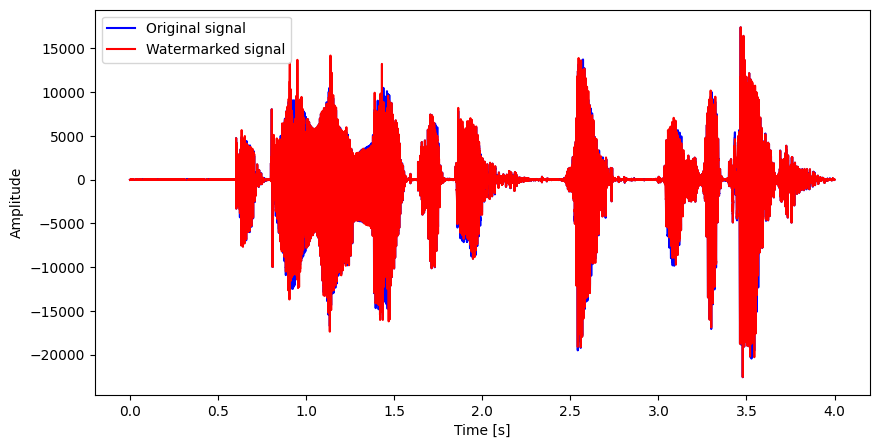

In [16]:
# Plot original and watermarked signal
plt.figure(figsize=(10, 5))
plt.plot(t_hamlet, hamlet_en, label="Original signal", color=(0, 0, 1.0, 1.0))
plt.plot(t_hamlet, watermarked_signal_ns, label="Watermarked signal", color=(1.0, 0, 0, 1.0))
# plt.xlim(0, 0.025)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

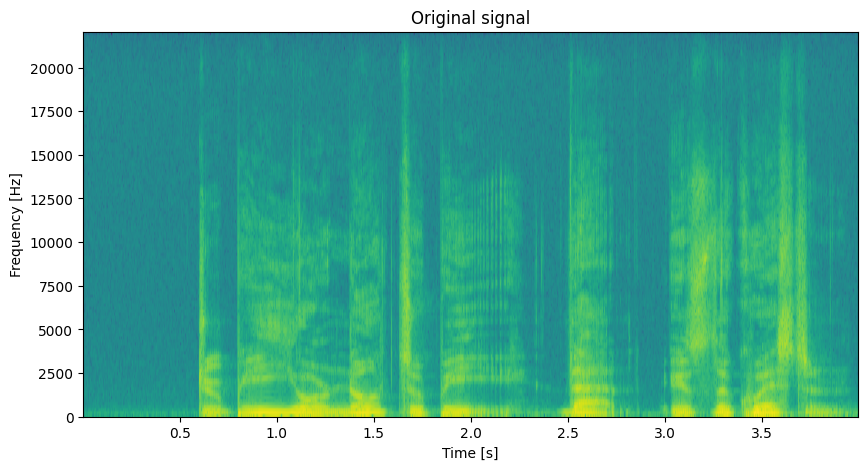

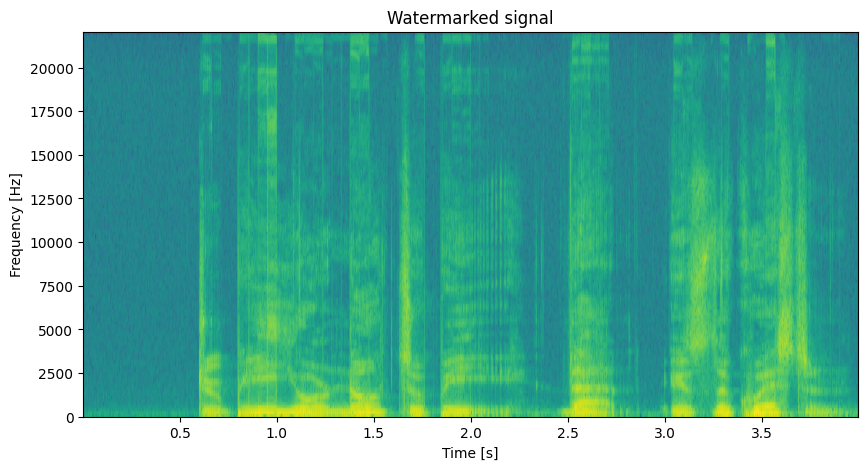

In [17]:
# Plot spectrogram of original and watermarked signal
plt.figure(figsize=(10, 5))
plt.specgram(hamlet_en, Fs=fs_hamlet)
plt.title("Original signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

plt.figure(figsize=(10, 5))
plt.specgram(watermarked_signal_ns, Fs=fs_hamlet)
plt.title("Watermarked signal")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.show()

In [18]:
watermarking_methods_df = pd.DataFrame.from_dict(watermarking_methods, orient='index')
watermarking_methods_df = watermarking_methods_df.round(2)
display(watermarking_methods_df)

SNR [dB]  BER [%]
Implementacion 1     10.03     0.25
Implementacion 2     34.50    20.12
Implementacion 3     13.18     0.00